In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import eipy.ei as e
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, TensorBoard, Callback
from tensorboard import notebook
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import LSTM,Dense, Bidirectional, GRU, Dropout 
from keras.layers import BatchNormalization, SimpleRNN, Input, Lambda, TimeDistributed
from keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import concurrent.futures
import inspect
import pickle as pkl
import warnings
import longitudinal_tadpole.pipeline as p
from eipy.multiclass_metrics import alt_nested_threshold_fmax
from eipy.multiclass_metrics import decide_with_thresholds
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [37]:
cwd = os.getcwd()
with open(f"/Users/susmaa01/Documents/eipy/longitudinal_tadpole/tadpole_data/tadpole_data_time_imptn_norm_thrshld30.pickle", "rb") as file:
    data_nested_dict = pkl.load(file)
with open(f"/Users/susmaa01/Documents/eipy/longitudinal_tadpole/tadpole_data/tadpole_labels_time_imptn_norm_thrshld30.pickle", "rb") as file:
    labels = pkl.load(file)

In [38]:
data_nested_dict.keys()

dict_keys(['bl', 'm06', 'm12', 'm24'])

In [39]:
for k, v in data_nested_dict['bl'].items():
    print(k, v.shape[1])

Main cognitive tests 9
MRI volumes 7
Demo, APOE4 & others 8
MRI ROI: Volume (WM Parcellation) 40
MRI ROI: Volume (Cortical Parcellation) 69
MRI ROI: Surface Area 68
MRI ROI: Cortical Thickness Average 68
MRI ROI: Cortical Thickness Standard Deviation 68


In [40]:
labels

,bl,m06,m12,m24,m36
0,NL,NL,NL,NL,NL
1,MCI,MCI,MCI,NL,MCI
2,NL,NL,NL,NL,NL
3,NL,NL,NL,NL,NL
4,NL,NL,NL,NL,NL
...,...,...,...,...,...
744,MCI,MCI,MCI,Dementia,NL
745,MCI,MCI,NL,NL,MCI
746,NL,NL,MCI,MCI,MCI
747,NL,MCI,MCI,MCI,MCI


In [41]:
concatenated_data = {}
for k,v in data_nested_dict.items():
    list_of_data_arrays = [data_array for data_array in v.values()]
    concatenated_data[k] = np.concatenate(list_of_data_arrays, axis=1)

In [42]:
X = np.stack([v for v in concatenated_data.values()], axis=1)

In [43]:
data, y = p.initial_data_label_prep(data_nested_dict, labels)

In [44]:
#prevalence of each label across time
for i in range(5):
    print(pd.Series(y[:,i]).value_counts()/len(y[:,i]))

1    0.728972
0    0.271028
Name: count, dtype: float64
1    0.690254
0    0.273698
2    0.036048
Name: count, dtype: float64
1    0.630174
0    0.288385
2    0.081442
Name: count, dtype: float64
1    0.526035
0    0.289720
2    0.184246
Name: count, dtype: float64
1    0.479306
0    0.283044
2    0.237650
Name: count, dtype: float64


In [45]:
# with open("/Users/susmaa01/Documents/eipy/eipy/longitudinal_tadpole/tadpole_data/rnn_data/X_30.pkl", "wb") as file:
#     pkl.dump(X, file=file)
# with open("/Users/susmaa01/Documents/eipy/eipy/longitudinal_tadpole/tadpole_data/rnn_data/y.pkl", "wb") as file:
#     pkl.dump(y, file=file)

# TIME SERIES TIME

In [46]:
def ohe(y):
    labels_across_time = np.eye(3)[y]

    return labels_across_time

In [47]:
y

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 1, 1],
       [0, 1, 1, 1, 1],
       [0, 1, 1, 1, 1]])

In [48]:
y_offset = y[:,1:]
for t in range(4):
    print(pd.Series(y_offset[:,t]).value_counts())

1    517
0    205
2     27
Name: count, dtype: int64
1    472
0    216
2     61
Name: count, dtype: int64
1    394
0    217
2    138
Name: count, dtype: int64
1    359
0    212
2    178
Name: count, dtype: int64


In [49]:
bl_diagnosis = y[:,0]
bl_dx = np.stack([bl_diagnosis]*4, axis=-1)
bl_dx = bl_dx.reshape(list(bl_dx.shape)+[1])
X_bl_dx = np.concatenate([X, bl_dx], axis=-1)
X_bl_dx.shape

(749, 4, 338)

In [50]:
def get_class_weights_for_t(training_labels):
    class_weights_for_labels = []
    for t in range(training_labels.shape[1]):
        bin_counts_per_t = len(training_labels) / 3 * np.bincount(training_labels[:,t])
        class_weights_t = dict(zip(range(3), bin_counts_per_t))
        class_weights_for_labels.append(class_weights_t)
    return class_weights_for_labels
    # mapped_array = [np.array([class_weights_for_labels[t][entry] for entry in training_labels[:,t]]) for t in range(training_labels.shape[1])]
    # mapped_array = np.stack(mapped_array, axis=1)
    # return tf.constant(mapped_array, dtype='float32')

In [51]:
def get_ordinal_class_weights_for_t(training_labels, gamma=0):
    ordinal_class_weights_for_labels = []
    samples, timepoints = training_labels.shape
    for t in range(timepoints):
        labels_t = training_labels[:,t]
        class_prevs_t = 1 / np.bincount(labels_t)
        print(class_prevs_t)
        class_prevs_t_ord = np.array([class_prevs_t[0] * class_prevs_t[1]/class_prevs_t[2], class_prevs_t[1], class_prevs_t[2] * class_prevs_t[1]/class_prevs_t[0]])
        class_prevs_t_ord = class_prevs_t_ord / np.sum(class_prevs_t_ord)
        class_weights_t = dict(zip(range(3), class_prevs_t_ord))
        ordinal_class_weights_for_labels.append(class_weights_t)
    return ordinal_class_weights_for_labels

In [52]:
def get_flat_class_weights(training_labels):
    flat_labels = training_labels.flatten()
    class_prevs = 1 / np.bincount(flat_labels)
    class_prevs /= np.sum(class_prevs)
    class_weights = dict(zip(range(3), class_prevs))

    return class_weights
get_flat_class_weights(y_offset)

{0: 0.27840377741242817, 1: 0.1358457008039977, 2: 0.5857505217835741}

In [53]:
def get_class_weights_up_to_t(training_labels):
    class_weights_for_labels = []
    for t in range(training_labels.shape[1]):
        labels_up_to_t = training_labels[:,:t+1]
        flat_labels = labels_up_to_t.flatten()
        bin_counts_per_t = 1 / np.bincount(flat_labels)
        norm_bin_counts_per_t = bin_counts_per_t/np.sum(bin_counts_per_t)
        class_weights_t = dict(zip(range(3), norm_bin_counts_per_t))
        class_weights_for_labels.append(class_weights_t)
    return class_weights_for_labels

In [54]:
#ordinal categorical crossentropy. Weighs error by how many classes output was off by. weights range from 1 to 2. assigns class weights across time.
# https://stats.stackexchange.com/questions/87826/machine-learning-with-ordered-labels
#gamma = d(MCI,CN) - d(MCI,Dementia) = d(MCI,CN) - 1

def occ_loss(gamma=0):
    global class_weights
    def loss(y_true, y_pred):
        y_true_ord = tf.argmax(y_true, axis=-1)
        y_pred_ord = tf.argmax(y_pred, axis=-1)

        losses_over_time = []
        for t in range(4):
            y_true_ord_t = y_true_ord[:,t]
            
            class_weights_t = class_weights[t]
            w_c_t = tf.gather(tf.constant(list(class_weights_t.values()), dtype=tf.float32),
                                y_true_ord_t)

            if gamma=='none':
                loss = tf.keras.losses.categorical_crossentropy(y_true[:,t], y_pred[:,t]) * w_c_t
            else:
                y_true_ord_gamma = y_true_ord_t + tf.cast(y_true_ord_t != 0, tf.int64) * gamma
                y_pred_ord_gamma = y_pred_ord[:,t] + tf.cast(y_pred_ord[:,t] != 0, tf.int64) * gamma
                w_o_t = tf.cast(tf.abs(y_true_ord_gamma - y_pred_ord_gamma) / (2 + gamma), dtype='float32') + 1
    
                loss = tf.keras.losses.categorical_crossentropy(y_true[:,t], y_pred[:,t]) * w_o_t * w_c_t

            losses_over_time.append(loss)
        return tf.reduce_mean(tf.stack(losses_over_time, axis=-1), axis=-1)
    return loss

In [55]:
# PPAD method that takes the follwing parametres:
# cell: it represents the RNN cell will be used {'GRU', 'biGRU', 'LSTM', 'biLSTM'}
# drout: it represents the drop out rate will be used {0, 0.1, 0.2, 0.3, 0.4, 0.5}
# L2: it represents the L2 regularization {0.1, 0.001, 0.00001, 0.0000001}
# ftp: it represents future time point to predict in PPAD its 1

def build_RNN(units, cell, drout, L2, deep=True, reg_layer='batchnorm', activation='relu', gamma=0):
    model = Sequential()
    
    params_dict_1 = {'units': units,
                     'activity_regularizer': l2(L2),
                     'dropout': drout,
                     'recurrent_dropout': drout,
                     'return_sequences': True}
    params_dict_2 = {'units': units // 2,
                     'activity_regularizer': l2(L2),
                     'dropout': drout,
                     'recurrent_dropout': drout,
                     'return_sequences': True}
    

    if cell =='RNN':
        model.add(SimpleRNN(**params_dict_1))
    elif cell == 'biGRU':
        model.add(Bidirectional(GRU(**params_dict_1)))
    elif cell == 'biLSTM':
        model.add(Bidirectional(LSTM(**params_dict_1)))
    elif cell == 'GRU':
        model.add(GRU(**params_dict_1))
    elif cell == 'LSTM':
        model.add(LSTM(**params_dict_1))
    
    
    if deep:
        model.add(Dropout(drout))
        if reg_layer=="batchnorm":
            model.add(BatchNormalization())
        
        if cell == 'RNN':
            model.add(SimpleRNN(**params_dict_2))
        if cell == 'biGRU':
            model.add(Bidirectional(GRU(**params_dict_2)))
        elif cell == 'biLSTM':
            model.add(Bidirectional(LSTM(**params_dict_2)))
        elif cell == 'GRU':
            model.add(GRU(**params_dict_2))
        elif cell == 'LSTM':
            model.add(LSTM(**params_dict_2))
        
    # model.add(Dropout(drout))
    # if reg_layer=="batchnorm":
    #     model.add(BatchNormalization())
    
    # MLP Classification model    
    model.add(Dense(units // 2 , activation=activation))
    model.add(Dropout(drout))
    if reg_layer=="batchnorm":
        model.add(BatchNormalization())        
    
    model.add(Dense(units // 4  , activation=activation))
    model.add(Dropout(drout))
    if reg_layer=="batchnorm":
        model.add(BatchNormalization())
    #to force overfitting
    # model.add(Dense(units // 8  , activation='relu'))
    # model.add(Dense(units // 16  , activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    # adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=occ_loss(gamma=gamma), optimizer='adam') # loss=occ_loss
    return model
#units=64, drout=0.2

In [56]:
def create_mlp(input, units, activation, drout, reg_layer='batchnorm'):
    x = Dense(units // 2, activation=activation)(input)
    x = Dropout(drout)(x)
    if reg_layer == "batchnorm":
        x = BatchNormalization()(x)
        
    # x = Dense(units // 4, activation=activation)(x)
    # x = Dropout(drout)(x)
    # if reg_layer == "batchnorm":
    #     x = BatchNormalization()(x)
        
    return x


def build_ALT_RNN(units, drout, deep=True, reg_layer='batchnorm', activation='tanh', gamma=0):
    input_layer = Input(shape=(None, X.shape[2]))

    x = LSTM(units, dropout=drout, recurrent_dropout=drout, return_sequences=True)(input_layer)
    
    if deep:
        x = LSTM(units // 2, dropout=drout, recurrent_dropout=drout, return_sequences=True)(x)
    
    outputs = []
    for i in range(4):
        timestep_output = Lambda(lambda t, i=i: t[:, i, :])(x)  # Extract the ith timestep
        mlp_output = create_mlp(input=timestep_output, 
                                units=units, activation=activation, drout=drout, reg_layer=reg_layer)
        outputs.append(mlp_output)

    c_input = Lambda(lambda x: tf.stack(x, axis=1))(outputs)

    c = TimeDistributed(Dense(units=units // 4, activation=activation))(c_input)
    c = Dropout(drout)(c)
    if reg_layer == "batchnorm":
        c = BatchNormalization()(c)
    
    c = TimeDistributed(Dense(units=units // 8, activation=activation))(c)
    c = Dropout(drout)(c)
    if reg_layer == "batchnorm":
        c = BatchNormalization()(c)
    
    output = TimeDistributed(Dense(3, activation='softmax'))(c)
    

    # Define the model
    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam', loss=occ_loss(gamma=gamma))
    return model

In [57]:
def dem_prev(label_seq):
    return [np.sum(y==2) for y in label_seq]

In [58]:
def resample(X,y):
    sampler = RandomOverSampler()
    X_flat = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
    X_flat_y = np.concatenate([X_flat, y], axis=1)
    
    X_y_resampled, _ = sampler.fit_resample(X_flat_y, dem_prev(y))
    
    X_resampled = X_y_resampled[:,:-y.shape[1]]
    X_resampled = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2])
    
    y_resampled = X_y_resampled[:,-y.shape[1]:].astype(int)

    return X_resampled, y_resampled

In [59]:
def fit_restandardize(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    #for restandardizing bl class 2 columns to be all -1
    means[means==0] = 1
    stds[stds == 0] = 1

    restandardized_data = (data-means)/stds

    return restandardized_data, means, stds

def restandardize(data, means, stds):

    return (data-means)/stds

In [60]:
def expectation(prob_vector):
    return int(np.round(np.dot([prob_vector], [-0.5,1,2.5])))

In [61]:
def compute_thresh_argmax(y_pred, thresh):
    if y_pred[1] > thresh:
        return 1
    else:
        if y_pred[0] > y_pred[2]:
            return 0
        else:
            return 2

In [62]:
def find_thresh(y_preds, y_trues, class_to_optimize='avg'):
    fmax = 0
    tmax = 0
    for t in np.unique(np.array(y_preds)[:,1]):
        y_decision = [compute_thresh_argmax(y,thresh=t) for y in y_preds]
        if class_to_optimize == 'avg':
            f = f1_score(y_trues, y_decision, average='macro')
        else:
            f = f1_score(y_trues, y_decision, average=None)[class_to_optimize]
        if f > fmax:
            fmax = f
            tmax = t
    return tmax

train lstms

In [65]:
#use data up to time point n, 
#e.g., when n=3 means use data from t=0,1,2 and predict on label from t=3
cell_list = ["LSTM"]#, "GRU"]#, 'RNN', "biLSTM", "biGRU"]
def train_eval_RNNs(seed, decision, cells=cell_list, random_bl=False, sampling=None, multiclass_weights='longitudinal', gamma=0):
    global f_scores_test
    global p_scores_test
    global r_scores_test
    global f_scores_train
    global p_scores_train
    global r_scores_train
    # global f_scores_train
    for cell in cells:
        y_preds_test = []
        y_tests = []
        
        y_preds_train = []
        y_trains = []
        
        
        skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
        for fold, (train_index, test_index) in enumerate(skf.split(X, dem_prev(y_offset)), 1):
            if random_bl==False:
                real="Real"
            else:
                real="Random"
            print(real, cell, "seed",seed+1, "fold", fold, "gamma=", gamma)
            
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_offset[train_index], y_offset[test_index]

            X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.09,
                                                                stratify=dem_prev(y_train), random_state=seed**2)
            
            # duplicate any sample that has dementia in its label sequence
            if sampling == 'oversampling':
                dem_rows = np.where(np.any(y_train == 2, axis=1))[0]
                X_dem, y_dem = X_train[dem_rows], y_train[dem_rows]

                X_train = np.concatenate([X_train, X_dem], axis=0)
                y_train = np.concatenate([y_train, y_dem], axis=0)
            
            elif sampling == 'dem_prev':
                X_train, y_train = resample(X_train, y_train)

            y_train_ohe, y_val_ohe = ohe(y_train), ohe(y_val)
            y_tests.append(y_test)
            y_trains.append(y_train)
            

            X_train, means, stds = fit_restandardize(X_train)
            X_test, X_val = restandardize(X_test, means=means, stds=stds), restandardize(X_val, means=means, stds=stds)

            global class_weights
            if multiclass_weights == 'sklearn':
                class_weights = [dict(zip(range(3), compute_class_weight(class_weight='balanced', classes=[0,1,2], y=y_train[:,t]))) for t in range(y_train.shape[1])]
            if multiclass_weights == 'longitudinal':
                class_weights = get_class_weights_for_t(y_train)
            elif multiclass_weights == 'aggregate':
                class_weights = get_class_weights_up_to_t(y_train)
            elif multiclass_weights == 'flat':
                class_weights = get_flat_class_weights(y_train)
            
            ###Build the model###

            # model = build_ALT_RNN(units=64, drout=0.2, deep=True,
            #                    activation='tanh', reg_layer='batchnorm', gamma=gamma)

            model = build_RNN(units=64, cell=cell, drout=0.2, deep=True, L2=0.00,
                               activation='tanh', reg_layer='batchnorm', gamma=gamma)
            
            early_stop = EarlyStopping(
                monitor='val_loss', patience=30, verbose=1,
                restore_best_weights=True, start_from_epoch=10)
            
            
            if random_bl:
                np.random.shuffle(y_train_ohe)
                np.random.shuffle(y_val_ohe)

            #fit model
            model.fit(X_train, y_train_ohe, epochs=2000, validation_data=[X_val, y_val_ohe],
                       verbose=1, callbacks=[early_stop])

            y_preds_train.append(model.predict(X_train))
            y_preds_test.append(model.predict(X_test))
        
        y_pred_test = np.concatenate(y_preds_test, axis=0)
        y_test = np.concatenate(y_tests, axis=0)
        
        y_pred_train = np.concatenate(y_preds_train, axis=0)
        y_train = np.concatenate(y_trains, axis=0)


        if decision == "argmax": # for doing traditional decision making
            f_scores_cell_seed_across_time_test = np.stack([f1_score(y_test[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            p_scores_cell_seed_across_time_test = np.stack([precision_score(y_test[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            r_scores_cell_seed_across_time_test = np.stack([recall_score(y_test[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])

        elif decision == 'expectation':
            f_scores_cell_seed_across_time_test = np.stack([fbeta_score(y_test[:,i], np.array([expectation(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None, beta=1) for i in range(y_test.shape[1])])
            p_scores_cell_seed_across_time_test = np.stack([precision_score(y_test[:,i], np.array([expectation(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            r_scores_cell_seed_across_time_test = np.stack([recall_score(y_test[:,i], np.array([expectation(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
        elif decision == 'threshmax':
            thresholds = [find_thresh(y_trues=y_train[:,i], y_preds=y_pred_train[:,i,:]) for i in range(y_train.shape[1])]
            f_scores_cell_seed_across_time_test = np.stack([f1_score(y_test[:,i], np.array([compute_thresh_argmax(y_hat, thresholds[i]) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            p_scores_cell_seed_across_time_test = np.stack([precision_score(y_test[:,i], np.array([compute_thresh_argmax(y_hat, thresholds[i]) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            r_scores_cell_seed_across_time_test = np.stack([recall_score(y_test[:,i], np.array([compute_thresh_argmax(y_hat, thresholds[i]) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            
        f_scores_test[f'{real} {cell}'].append(f_scores_cell_seed_across_time_test)
        p_scores_test[f'{real} {cell}'].append(p_scores_cell_seed_across_time_test)
        r_scores_test[f'{real} {cell}'].append(r_scores_cell_seed_across_time_test)
            # f_scores_cell_seed_across_time_train = np.stack([fbeta_score(y_train[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_train[:,i,:]]), average=None, beta=1) for i in range(y_train.shape[1])])
            # f_scores_train[f'{real} {cell}'].append(f_scores_cell_seed_across_time_train)

            # p_scores_cell_seed_across_time_train = np.stack([precision_score(y_train[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_train[:,i,:]]), average=None) for i in range(y_train.shape[1])])
            # p_scores_train[f'{real} {cell}'].append(p_scores_cell_seed_across_time_train)

            # r_scores_cell_seed_across_time_train = np.stack([recall_score(y_train[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_train[:,i,:]]), average=None) for i in range(y_train.shape[1])])
            # r_scores_train[f'{real} {cell}'].append(r_scores_cell_seed_across_time_train)
            
            # f_scores_cell_seed_across_time_train = np.stack([fbeta_score(y_train[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_train[:,i,:]]), average=None, beta=1) for i in range(y_train.shape[1])])
            # f_scores_train[cell].append(f_scores_cell_seed_across_time_train)
            
            # y_pred_argmax = [np.argmax(y_hat) for y_hat in y_pred]
            # f_scores[cell].append(f1_score(y_test, y_pred_argmax, average=None))

        # else: # for deciding with nested fmax scheme
        #     X_not_test = np.concatenate([X_train, X_val], axis=0)
        #     y_not_test = np.concatenate([y_train, y_val], axis=0)
        #     y_not_test = np.array([np.argmax(ohe_label, axis=-1) for ohe_label in y_not_test]) # convert back to ordinal
        #     threshold_pair = alt_nested_threshold_fmax(y_not_test, model.predict(X_not_test))[1]
        #     y_decision = decide_with_thresholds(y_pred=y_pred, t_pair=threshold_pair)
        #     f_scores_test[cell].append([f1_score(y_test, y_decision, average=None), threshold_pair])
        print(f_scores_test)
        # print(f_scores_train)

In [66]:
seeds=5
f_scores_test = dict()
p_scores_test = dict()
r_scores_test = dict()
# f_scores_train = dict()
for cell in cell_list:
    for real in ['Real', 'Random']:
        f_scores_test[f'{real} {cell}'] = []
        p_scores_test[f'{real} {cell}'] = []
        r_scores_test[f'{real} {cell}'] = []
        # f_scores_train[f'{real} {cell}'] = []
# f_scores_train = {k: [] for k in cell_list} #gets score distribution for diff cells across splits
for seed in range(seeds):
    for gamma in range(5):
        train_eval_RNNs(seed=seed, decision='threshmax', random_bl=False, sampling=None, multiclass_weights='sklearn', gamma=2)
    # train_eval_RNNs(seed=seed, decision='argmax', random_bl=True, sampling=None, multiclass_weights='longitudinal')
# f_score_arrays_test = {k: np.stack(v, axis=0) for k,v in f_scores_test.items()}
# p_score_arrays_test = {k: np.stack(v, axis=0) for k,v in p_scores_test.items()}
# r_score_arrays_test = {k: np.stack(v, axis=0) for k,v in r_scores_test.items()}
# f_score_arrays_train = {k: np.stack(v, axis=0) for k,v in f_scores_train.items()}

Real LSTM seed 1 fold 1 gamma= 2
Epoch 1/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.2293 - val_loss: 1.6156
Epoch 2/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8004 - val_loss: 1.5394
Epoch 3/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8896 - val_loss: 1.5270
Epoch 4/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7982 - val_loss: 1.5178
Epoch 5/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8405 - val_loss: 1.5435
Epoch 6/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7149 - val_loss: 1.5625
Epoch 7/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6272 - val_loss: 1.5711
Epoch 8/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7156 - val_loss: 1.5701
Epoch 9/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7005 - val_loss: 1.5513
Epoch 10/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5566 - val_loss: 1.5672
Epoch 11/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5052 - val_loss: 1.5747
Epoch 12/2000
18

In [67]:
f_scores_gamma = { f'gamma={gamma}': np.stack([item for index, item in enumerate(f_scores_test['Real LSTM']) if index % 5 == gamma], axis=0) for gamma in range(5)}
p_scores_gamma = { f'gamma={gamma}': np.stack([item for index, item in enumerate(p_scores_test['Real LSTM']) if index % 5 == gamma], axis=0) for gamma in range(5)}
r_scores_gamma = { f'gamma={gamma}': np.stack([item for index, item in enumerate(r_scores_test['Real LSTM']) if index % 5 == gamma], axis=0) for gamma in range(5)}

In [68]:
for seed in range(seeds):
    train_eval_RNNs(seed=seed, decision='threshmax', random_bl=False, sampling=None, multiclass_weights='sklearn', gamma='none')

Real LSTM seed 1 fold 1 gamma= none
Epoch 1/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.4055 - val_loss: 1.0966
Epoch 2/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1845 - val_loss: 1.0922
Epoch 3/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2104 - val_loss: 1.0886
Epoch 4/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1223 - val_loss: 1.0886
Epoch 5/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1298 - val_loss: 1.0872
Epoch 6/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1208 - val_loss: 1.0831
Epoch 7/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0371 - val_loss: 1.0851
Epoch 8/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0754 - val_loss: 1.0845
Epoch 9/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1022 - val_loss: 1.0870
Epoch 10/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0328 - val_loss: 1.0934
Epoch 11/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0822 - val_loss: 1.0893
Epoch 12/2000
1

In [71]:
f_scores_gamma['no gamma'] = np.stack(f_scores_test['Real LSTM'][-5:], axis=0)
p_scores_gamma['no gamma'] = np.stack(p_scores_test['Real LSTM'][-5:], axis=0)
r_scores_gamma['no gamma'] = np.stack(r_scores_test['Real LSTM'][-5:], axis=0)

In [72]:
# results = {'f': f_score_arrays_test, 'p': p_score_arrays_test, 'r': r_score_arrays_test}
# with open("/Users/susmaa01/Documents/eipy/longitudinal_tadpole/baseline_results/sequential_RNNs_plain_loss.pkl", "wb") as file:
#     pkl.dump(obj=results, file=file)

In [73]:
# with open("/Users/susmaa01/Documents/eipy/longitudinal_tadpole/baseline_results/sequential_RNNs.pkl", "rb") as file:
#     f_scores_normal_loss = pkl.load(file=file)

In [74]:
def plot_class_scores(score_dict, dict_name, class_to_plot='Dementia'):
    # Assuming f_score_arrays is your dictionary of 2D arrays
    # Example dictionary of 2D arrays
    if class_to_plot == 'CN':
        class_scores = {k: v[:,:,0] for k,v in score_dict.items()}
    elif class_to_plot == 'MCI':
        class_scores = {k: v[:,:,1] for k,v in score_dict.items()}
    elif class_to_plot == 'Dementia':
        class_scores = {k: v[:,:,-1] for k,v in score_dict.items()}
    elif class_to_plot == 'all':
        class_scores = {k: np.mean(v, axis=-1) for k,v in score_dict.items()}
        
    # Compute medians
    medians = {key: np.median(arr, axis=0) for key, arr in class_scores.items()}

    # Compute standard errors with respect to medians
    std_errors = {
        key: np.median(np.abs(arr - np.median(arr, axis=0)), axis=0) / np.sqrt(arr.shape[0])
        for key, arr in class_scores.items()
    }

    # X ticks and labels
    x_ticks = np.arange(4)
    x_labels = ['up to bl vs m06', 'up to m06 vs m12', 'up to m12 vs m24', 'up to m24 vs m36']

    # Plotting
    plt.figure(figsize=(10, 6))
    for key in score_dict:
        plt.errorbar(x_ticks, medians[key], yerr=std_errors[key], label=key)

    plt.xticks(x_ticks, x_labels)

    if class_to_plot != 'all':
        plt.title(f'{dict_name} scores on {class_to_plot} class from seq2seq baselines')
    else:
        plt.title(f'macro averaged {dict_name} scores from seq2seq baselines')
    plt.xlabel('data up to time t matched with labels from time t+1')
    plt.ylabel(f'median {dict_name} score')
    plt.legend()
    plt.show()

In [75]:
f_scores_test

{'Real LSTM': [array([[0.32024169, 0.7418738 , 0.04958678],
         [0.44949495, 0.67895879, 0.1       ],
         [0.36363636, 0.61320755, 0.20377358],
         [0.41050119, 0.58807947, 0.22839506]]),
  array([[0.24285714, 0.77690289, 0.08      ],
         [0.43577982, 0.6409966 , 0.13407821],
         [0.39830508, 0.51515152, 0.17333333],
         [0.42342342, 0.52647059, 0.24064171]]),
  array([[0.32615385, 0.74952919, 0.05405405],
         [0.37878788, 0.67593583, 0.11976048],
         [0.40189125, 0.6097561 , 0.17254902],
         [0.44742729, 0.60714286, 0.27244582]]),
  array([[0.29126214, 0.77413479, 0.04395604],
         [0.47281324, 0.67178924, 0.12195122],
         [0.41955193, 0.56551724, 0.17730496],
         [0.44628099, 0.56296296, 0.22418879]]),
  array([[0.38068182, 0.74088292, 0.01923077],
         [0.42377261, 0.69978858, 0.0969697 ],
         [0.37002342, 0.60635697, 0.17391304],
         [0.43652561, 0.58970793, 0.24242424]]),
  array([[0.34985423, 0.75397568, 0.0

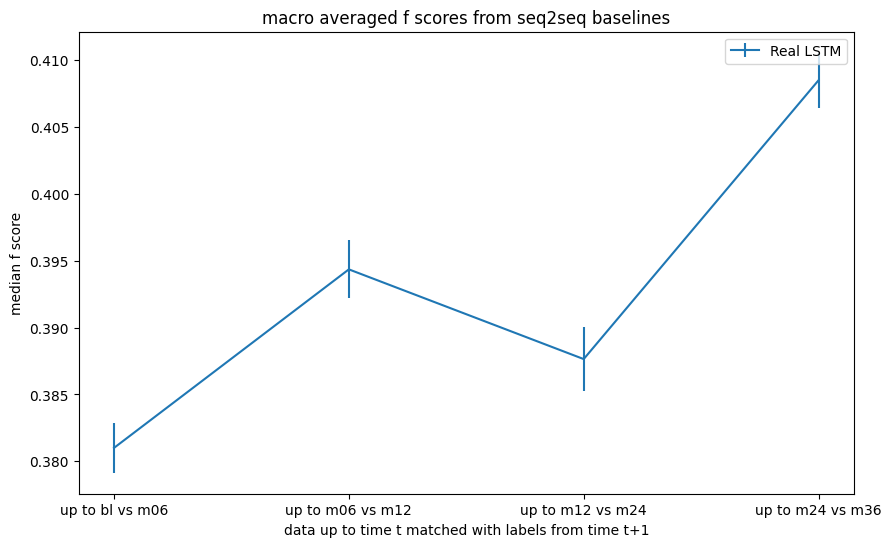

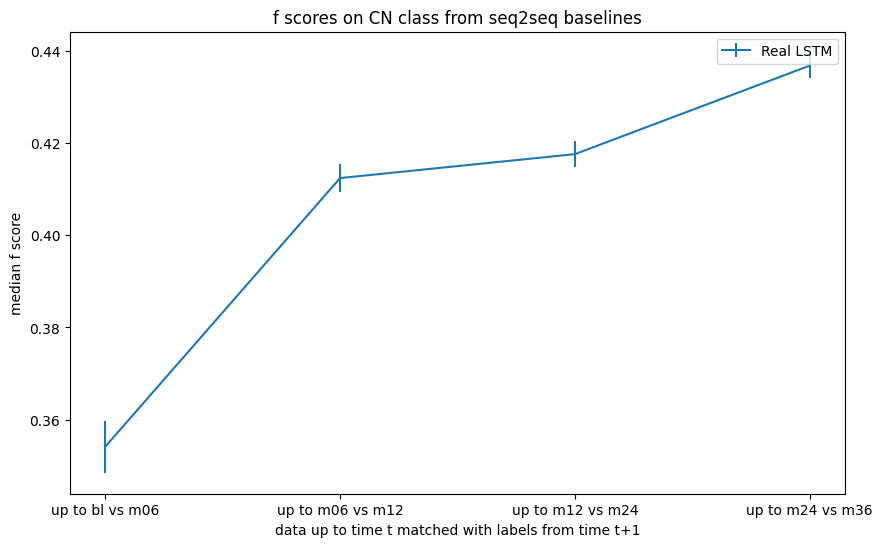

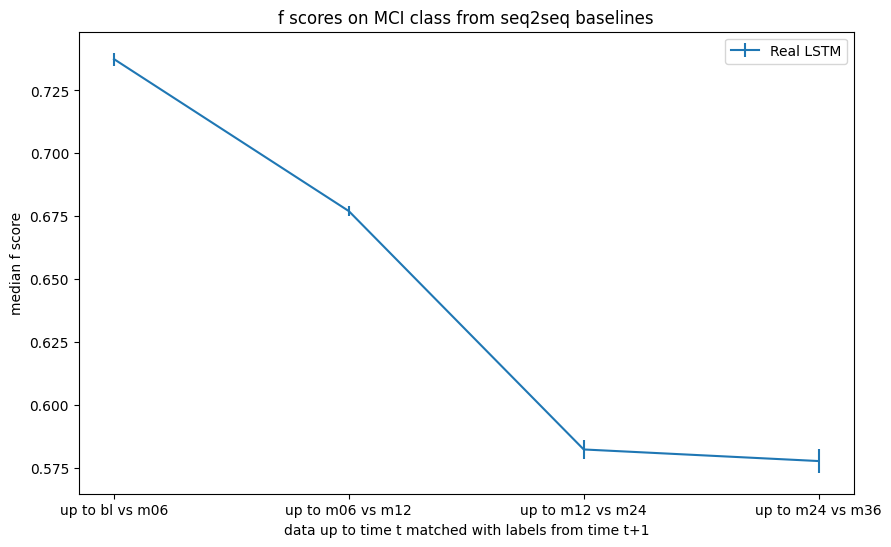

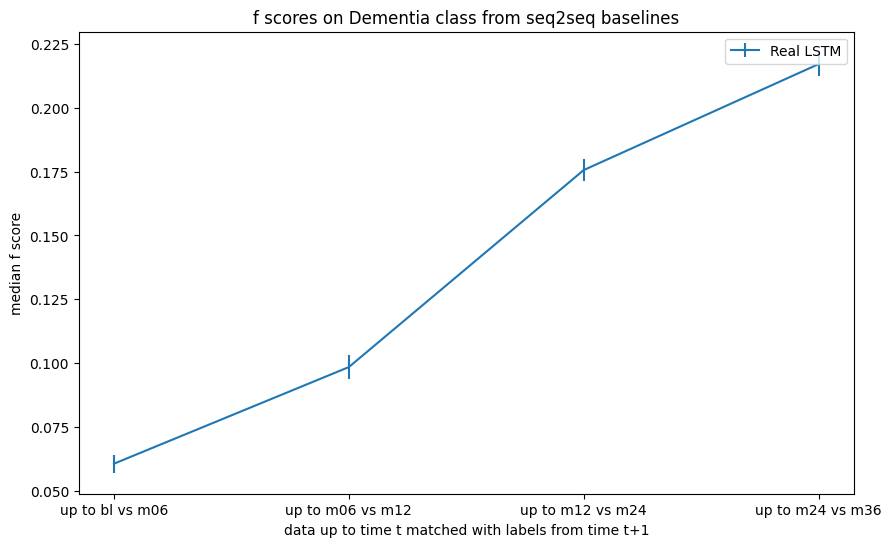

In [76]:
f_score_arrays_test = {k: np.stack(v, axis=0) for k,v in f_scores_test.items() if "Real" in k}
plot_class_scores(score_dict=f_score_arrays_test, dict_name='f', class_to_plot='all')
plot_class_scores(score_dict=f_score_arrays_test, dict_name='f', class_to_plot='CN')
plot_class_scores(score_dict=f_score_arrays_test, dict_name='f', class_to_plot='MCI')
plot_class_scores(score_dict=f_score_arrays_test, dict_name='f', class_to_plot='Dementia')

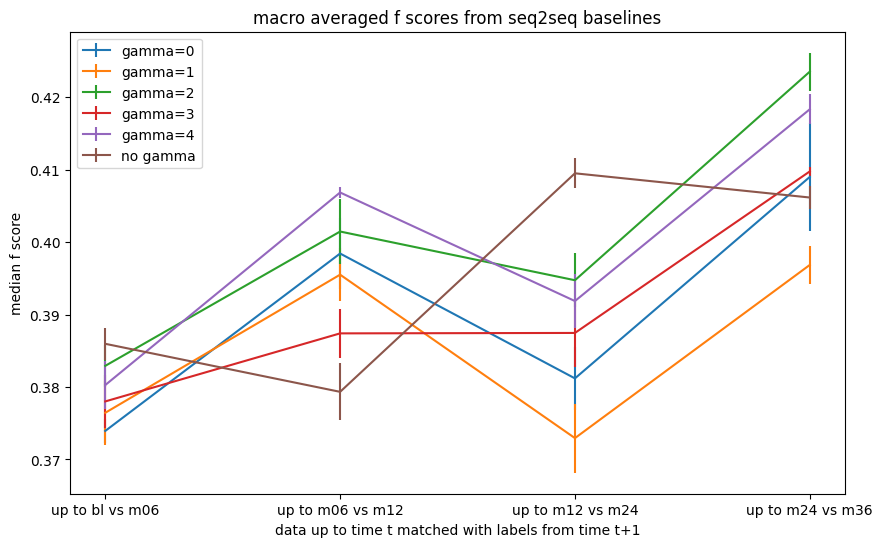

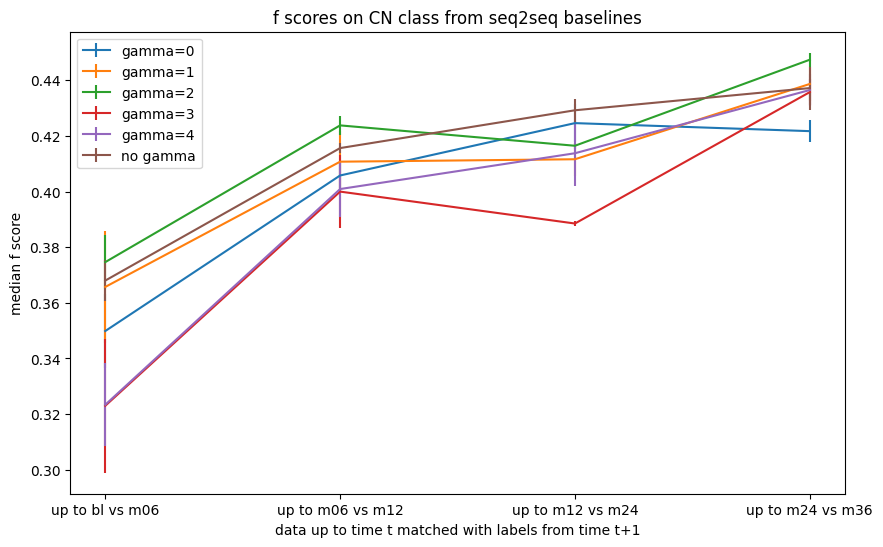

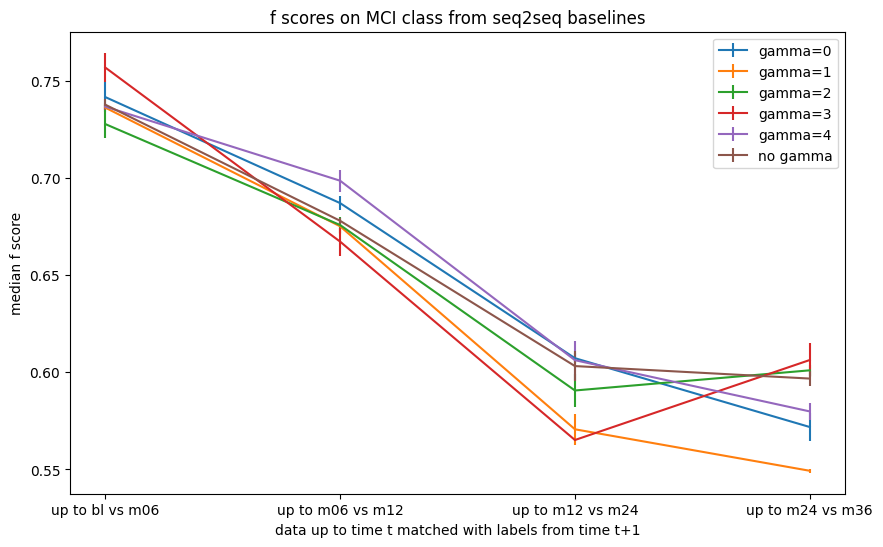

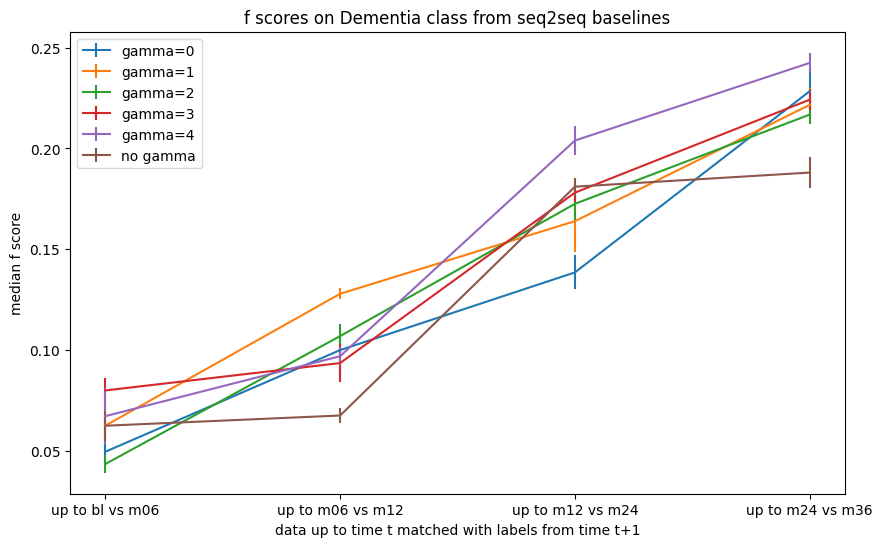

In [77]:
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='all')
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='CN')
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='MCI')
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='Dementia')

In [78]:
results_gamma = {'f': f_scores_gamma, 'p': p_scores_gamma, 'r': r_scores_gamma}
with open("/Users/susmaa01/Documents/eipy/longitudinal_tadpole/results/gamma_tuning/base_threshmax_fixed.pkl", "wb") as file:
    pkl.dump(obj=results_gamma, file=file)

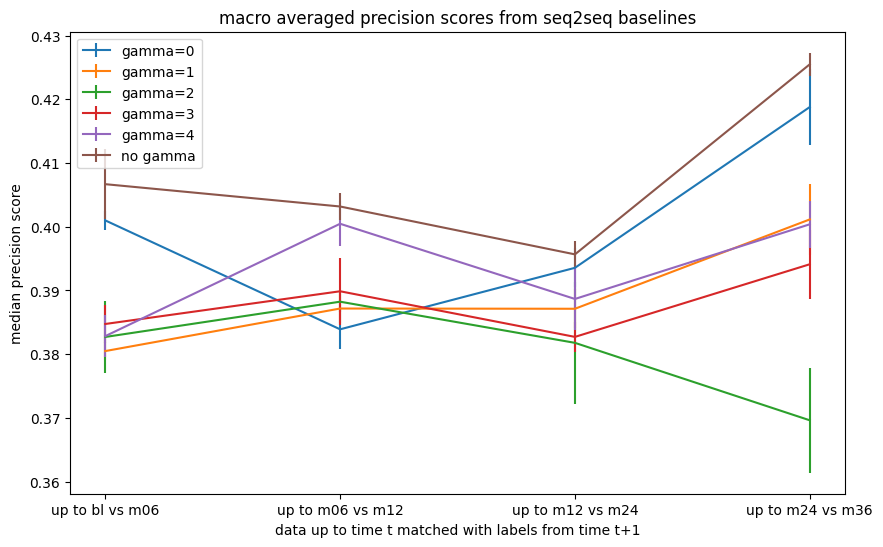

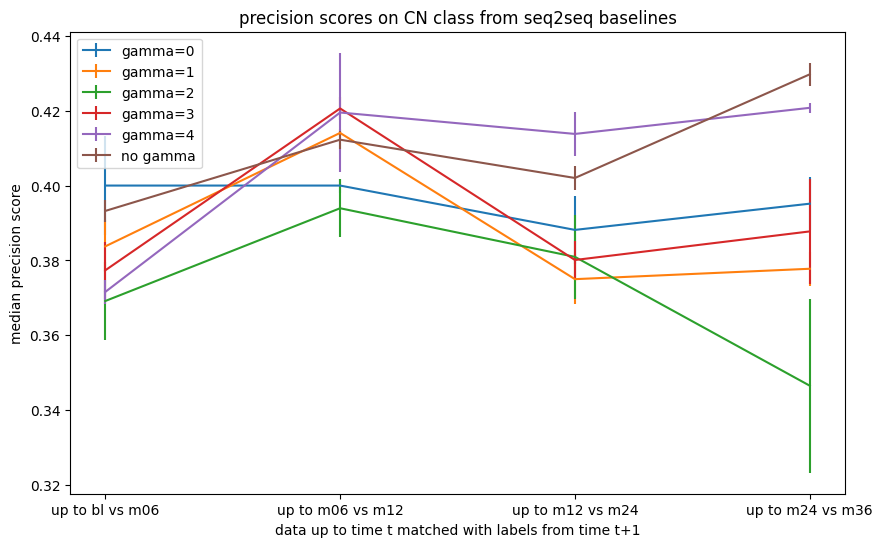

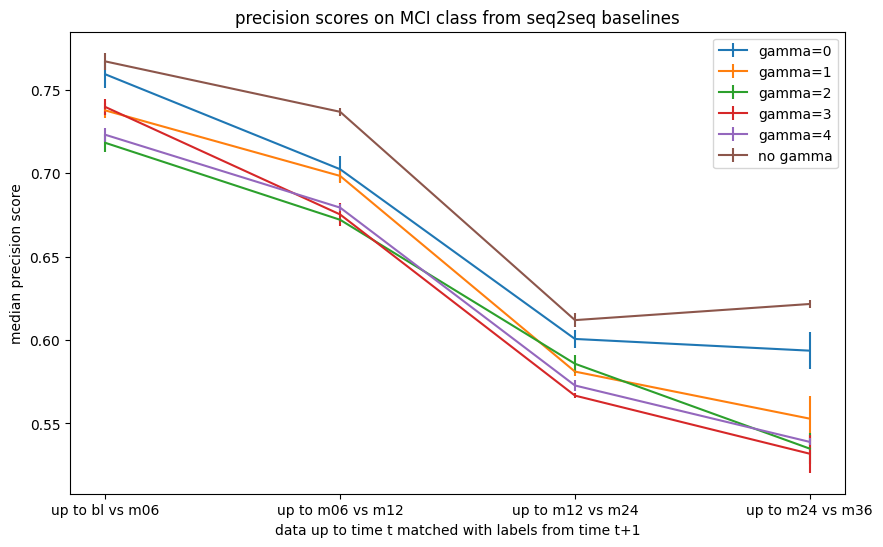

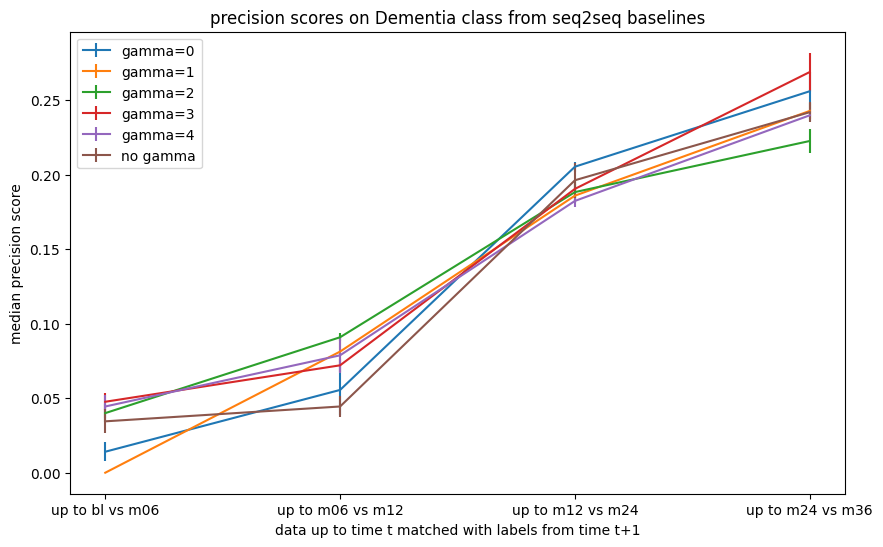

In [192]:
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='all')
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='CN')
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='MCI')
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='Dementia')

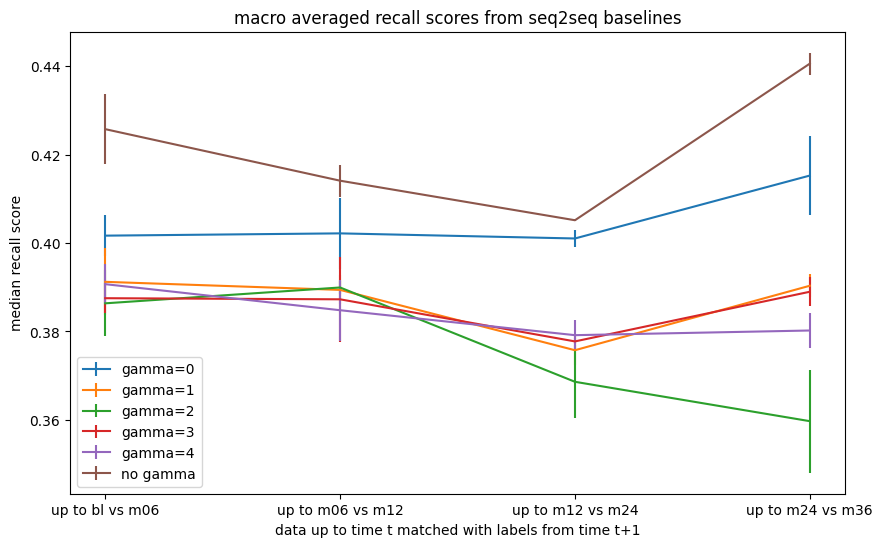

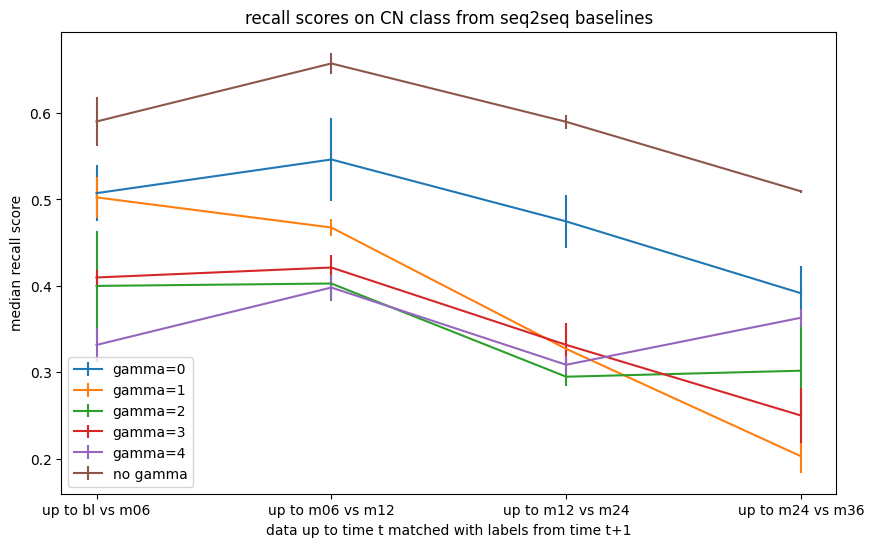

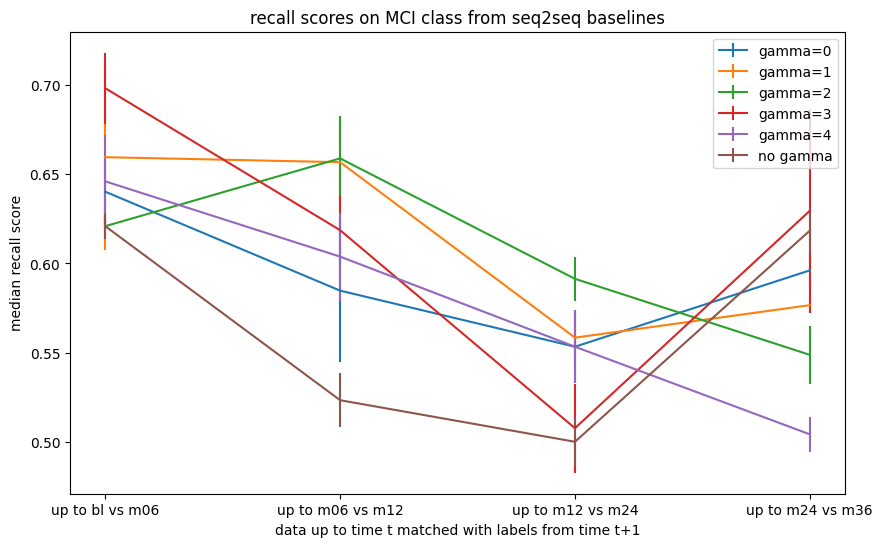

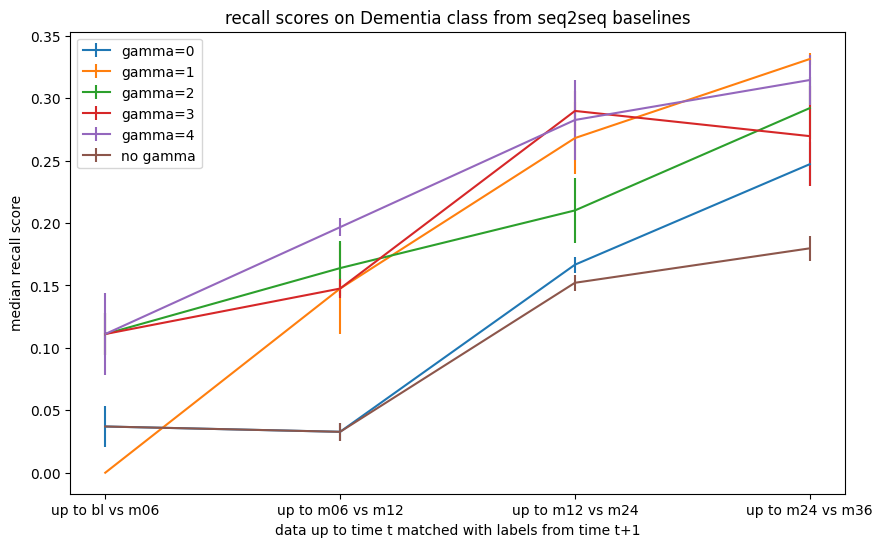

In [193]:
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='all')
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='CN')
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='MCI')
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='Dementia')

In [ ]:
# f_score_arrays_train = {k: np.stack(v, axis=0) for k,v in f_scores_train.items()}
# plot_class_scores(score_dicts=f_score_arrays_train, class_to_plot='all')
# plot_class_scores(score_dicts=f_score_arrays_train,class_to_plot='CN')
# plot_class_scores(score_dicts=f_score_arrays_train,class_to_plot='MCI')
# plot_class_scores(score_dicts=f_score_arrays_train, class_to_plot='Dementia')

In [ ]:
# plot_class_scores(score_dicts=f_scores_normal_loss, class_to_plot='all')
# plot_class_scores(score_dicts=f_scores_normal_loss,class_to_plot='CN')
# plot_class_scores(score_dicts=f_scores_normal_loss,class_to_plot='MCI')
# plot_class_scores(score_dicts=f_scores_normal_loss, class_to_plot='Dementia')